<a href="https://colab.research.google.com/github/szilardnemeth/pytorch-tutorial/blob/master/08_apply_0D_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade Pillow
import os
os.kill(os.getpid(), 9)

In [ ]:
import os
import time

import cv2
import torch
import numpy as np
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights

from torchvision.utils import draw_bounding_boxes, make_grid
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
from torchvision import transforms

import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image, ImageDraw, ImageFont

def draw_bounding_boxes_custom(image, boxes, labels, scores, object_color_mapping,
                               confidence_threshold, line_width=5, font_size=12,
                               display_text=True, selected_labels="all"):
    """
    Draw bounding boxes on an image.

    Args:
    - image: pytorch tensor
    - boxes: List of bounding boxes, where each box is represented as [x_min, y_min, x_max, y_max].
    - labels: List of class labels corresponding to each bounding box.
    - object_color_mapping: Dictionary mapping class labels to RGB colors.
    """
    if (selected_labels == "all") or (selected_labels is None):
        selected_labels = labels
    image_pil = to_pil_image(image)
    draw = ImageDraw.Draw(image_pil)

    for box, label, score in zip(boxes, labels, scores):
        if (score < confidence_threshold) or (label not in selected_labels):
            continue
        x_min, y_min, x_max, y_max = box
        color = object_color_mapping.get(label, "gray")  # Default to white if color not specified
        draw.rectangle([x_min, y_min, x_max, y_max], outline=color, width=line_width)
        if display_text:
            draw.text((x_min, y_min), f"{label}, {score: 0.2f}", fill=color, font_size=font_size)

    return image_pil

# Model

In [ ]:
if torch.cuda.is_available():
    print("GPU is not available.")
    device = torch.device('cuda')
    # or tensor_on_gpu = tensor.cuda()
else:
    print("GPU is not available.")
    device = torch.device('cpu')

In [ ]:
box_score_thresh = 0.1

# weights = RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT
# model = retinanet_resnet50_fpn_v2(weights=weights, box_score_thresh=box_score_thresh)
# model_name_str = "RetinaNet_ResNet50_FPN_V2"

# weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
# model = retinanet_resnet50_fpn(weights=weights, box_score_thresh=box_score_thresh)
# model_name_str = "RetinaNet_ResNet50_FPN"

# weights = FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
# model = fasterrcnn_mobilenet_v3_large_fpn(weights=weights, box_score_thresh=box_score_thresh)
# model_name_str = "FasterRCNN"

weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=box_score_thresh)
model_name_str = "FasterRCNN_ResNet50"

# weights = SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
# model = ssdlite320_mobilenet_v3_large(weights=weights, box_score_thresh=box_score_thresh)
# model_name_str = "SSDLite320_MobileNet_V3_Large"

# weights = SSD300_VGG16_Weights.DEFAULT
# model = ssd300_vgg16(weights=weights, box_score_thresh=box_score_thresh)
# model_name_str = "SSD300_VGG16"

model.to(device)

categories = weights.meta["categories"]
model.eval()
preprocess = weights.transforms()

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 163MB/s]


# Setup video

In [ ]:
# video_filename = "Esquina_Democratica.mp4"
# video_filename = "P1033659.mp4"
# video_filename = "P1033778.mp4"
# video_filename = "rainning_on_the_road.mov"
# video_filename = "GOPR0058.mp4"
# video_filename = "443_motorway_with_cars_1.mp4"
# video_filename = "vlc-record-2023-11-27-21h11m55s-Idiots In Cars Compilation - 355 [USA & Canada Only.mp4"
# video_filename = "dashcam_01.mp4"
# video_filename = "dashcam_02.mp4"
# video_filename = "dashcam_03.mp4"
video_filename = "Driving from Night into Dawn Dashcam 720p_3230-3245.mp4"

# desired_size = (1024, 768)
desired_size = (1280, 720)

# -----------------------------------------------
path_to_input_video = f"/content/drive/MyDrive/data/video/{video_filename}"
if not os.path.exists(path_to_input_video):
    print(f"File `{path_to_input_video}` does not exists")

# OpenCV VideoCapture object
cap = cv2.VideoCapture(path_to_input_video)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Couldn't open video.")
    # exit()

fps = cap.get(cv2.CAP_PROP_FPS)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_length_sec = num_frames/fps

desired_aspect_ratio = width/height
final_size = (int(desired_size[0]/desired_aspect_ratio), desired_size[0])

# Print the retrieved information
print("")
print("-"*50)
print(f"Frames per second (fps): {fps: 0.2f}")
print(f"Video length (sec): {video_length_sec: 0.2f}")
print(f"Number of frames: {num_frames}")
print(f"Resolution: {width} x {height}")
print(f"Desired size: {desired_size}")
print(f"Final size: {final_size}")


--------------------------------------------------
Frames per second (fps):  45.05
Video length (sec):  102.70
Number of frames: 4626
Resolution: 1280 x 720
Desired size: (1280, 720)
Final size: (720, 1280)


## Read one frame

In [ ]:
selected_frame = 2795
confidence_threshold = 0.1
is_crop = True
left, top, right, bottom = 500, 200, 1280, 720

object_color_mapping = {"car": "red", "person": "lime", "truck": "blue", "traffic light": "yellow", "bus": "magenta"}

#----------------------------------
resize_transform = transforms.Resize(final_size, antialias=False)

cap.set(cv2.CAP_PROP_POS_FRAMES, selected_frame)
ret, cv_frame = cap.read()
if not ret:
    print(f"Error: Could not read frame {selected_frame}.")

pil_image = Image.fromarray(cv2.cvtColor(cv_frame, cv2.COLOR_BGR2RGB))
tensor_frame = pil_to_tensor(pil_image)
tensor_frame = resize_transform(tensor_frame)
batch = preprocess(tensor_frame.unsqueeze(0).to('cuda'))

with torch.no_grad():
    t0 = time.time()
    prediction = model(batch)[0]
    print(f"Prediction time: {time.time()-t0: 0.4f}sec")
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
scores = [score for score in prediction['scores'].cpu().numpy()]
boxes = prediction["boxes"]

pil_w_boxes = draw_bounding_boxes_custom(tensor_frame, boxes=boxes, labels=labels,
                                         scores=scores, confidence_threshold=confidence_threshold,
                                         object_color_mapping=object_color_mapping,
                                         line_width=2, font_size=12,
                                         display_text=True, selected_labels=["car"])
print("-"*50)
print(f"|{model.__class__.__name__}|")
print(f"|{model_name_str}|, threshold: {confidence_threshold}, frame: {selected_frame}.")

if is_crop:
    pil_w_boxes_cropped = pil_w_boxes.crop((left, top, right, bottom))
else:
    pil_w_boxes_cropped = pil_w_boxes


draw = ImageDraw.Draw(pil_w_boxes_cropped)
image_title = f"|{model_name_str}|, threshold: {confidence_threshold}, frame: {selected_frame}."
draw.text((10, 10), image_title, font_size=18, fill="white")

pil_w_boxes_cropped

NameError: ignored

In [ ]:
model.names

['0']

In [ ]:
tensor_frame = pil_to_tensor(pil_image)
resize_transform_yolop = transforms.Resize((640, 640), antialias=False)
tensor_frame = resize_transform_yolop(tensor_frame)
print(tensor_frame.shape)

tensor_frame = tensor_frame.unsqueeze(0).float().to('cuda')
# img2 = torch.randn(1,3,640,640).to('cuda')

#inference
det_out, da_seg_out,ll_seg_out = model(tensor_frame)

torch.Size([3, 640, 640])


In [ ]:
det0 = det_out[0].squeeze()
det0 = det0.detach().cpu().numpy()

In [ ]:
df_det0 = pd.DataFrame(det0)

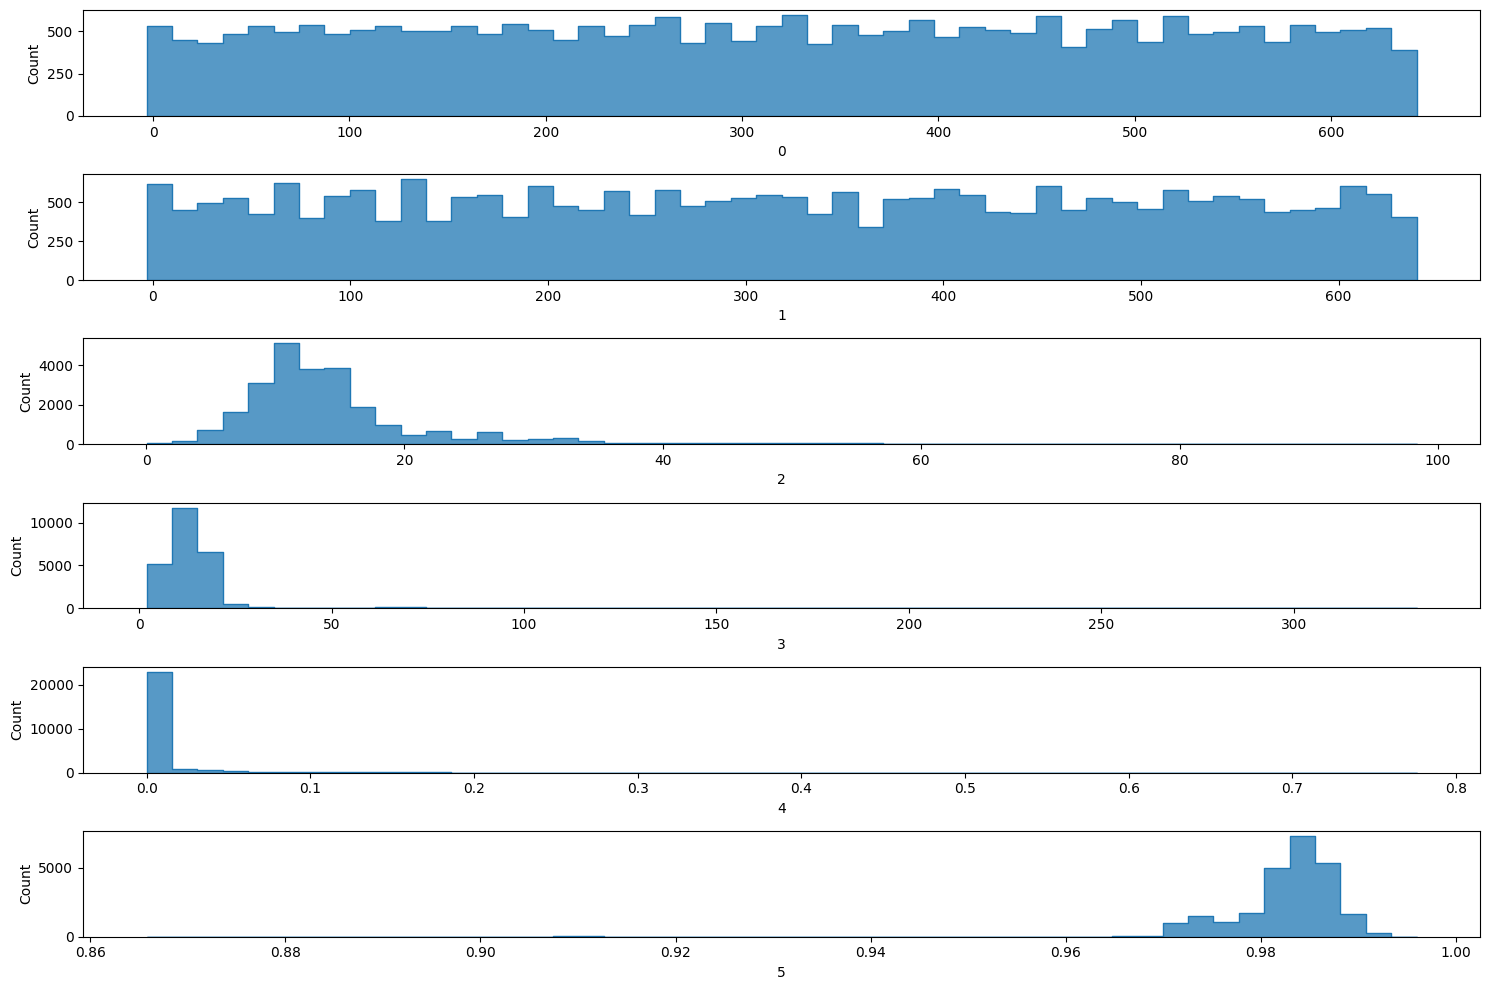

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=[15, 10], sharex=False)
for tax, col in zip(ax, df_det0.columns):
    sns.histplot(ax=tax, data=df_det0[col], bins=50, label=col, element='step')
plt.tight_layout()

## Multiple frames as grid

In [ ]:
# frames_ids = "auto"
frames_ids = list(range(2850, 2874, 2))

n_selection = 12
nrow = 4

confidence_threshold = 0.1
is_crop = True
left, top, right, bottom = 500, 200, 1280, 720

#----------------------------------

if frames_ids == "auto":
    delta = num_frames/(n_selection-1)
    frames_ids = [int(i*delta) for i in range(n_selection)]
    frames_ids[-1] = num_frames-3

resize_transform = transforms.Resize(final_size, antialias=False)

t0 = time.time()
gridframes = []
for selected_frame in frames_ids:
    cap.set(cv2.CAP_PROP_POS_FRAMES, selected_frame)
    ret, cv_frame = cap.read()
    if not ret:
        print(f"Error: Could not read frame {selected_frame}.")

    pil_image = Image.fromarray(cv2.cvtColor(cv_frame, cv2.COLOR_BGR2RGB))
    tensor_frame = pil_to_tensor(pil_image)
    tensor_frame = resize_transform(tensor_frame)
    batch = preprocess(tensor_frame.unsqueeze(0).to('cuda'))

    with torch.no_grad():
        t1 = time.time()
        prediction = model(batch)[0]
        print(f"Prediction time: {time.time()-t1: 0.4f}sec")
    labels = [weights.meta["categories"][i] for i in prediction["labels"]]
    scores = [score for score in prediction['scores'].cpu().numpy()]
    boxes = prediction["boxes"]

    object_color_mapping = {"car": "red", "person": "lime", "truck": "blue", "traffic light": "yellow", "bus": "magenta"}

    pil_w_boxes = draw_bounding_boxes_custom(tensor_frame,
                                boxes=boxes,
                                labels=labels,
                                scores=scores,
                                confidence_threshold=confidence_threshold,
                                object_color_mapping=object_color_mapping, line_width=5, font_size=12,
                                             display_text=True, selected_labels=["car"])
    # print("-"*50)
    # print(f"|{model.__class__.__name__}|")
    print(f"\b |{model_name_str}|, threshold: {confidence_threshold}, frame: {selected_frame}.")


    if is_crop:
        pil_w_boxes_cropped = pil_w_boxes.crop((left, top, right, bottom))
    else:
        pil_w_boxes_cropped = pil_w_boxes
    draw = ImageDraw.Draw(pil_w_boxes_cropped)
    image_title = f"|{model_name_str}|, threshold: {confidence_threshold}, frame: {selected_frame}."
    draw.text((10, 10), image_title, font_size=18, fill="white")

    tensor_frame_w_box = pil_to_tensor(pil_w_boxes_cropped)
    gridframes.append(tensor_frame_w_box)
print(f"Total time: {time.time()-t0: 0.4f}sec")

# Create a grid from the images
grid = make_grid(gridframes, nrow=nrow)

# Display the grid (optional)
pil_grid = transforms.ToPILImage()(grid)
pil_grid


# Process the whole video

In [ ]:
video_snippet_length_sec = -1
# video_snippet_length_sec = 10

confidence_threshold = 0.2
object_color_mapping = {"car": "red", "person": "lime", "truck": "blue", "traffic light": "yellow", "bus": "magenta"}
modifier = "caronly"

#----------------------------------
if video_snippet_length_sec > video_length_sec:
    print(f"The video is only {video_length_sec}sec long.")
    video_snippet_length_sec = video_length_sec

if (video_snippet_length_sec == -1):
    n_frames_to_read = num_frames
else:
    n_frames_to_read = int(video_snippet_length_sec*fps) - 1

n_frames_to_read = 4620

# Video set up
if cap.isOpened():
    cap.release()
    print("Releasing video.")

if not cap.isOpened():
    cap = cv2.VideoCapture(path_to_input_video)
    print("Reconnect to video.")

resize_transform = transforms.Resize(final_size, antialias=False)
width_out, height_out = final_size[1], final_size[0]  # Width and height of the frames
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Video codec

# Create a VideoWriter object
video_filename_noext, extension = os.path.splitext(video_filename)
video_filename_out = f"{video_filename_noext}_{model_name_str}_{confidence_threshold}{modifier}.mp4"
output_video_path = f"/content/drive/MyDrive/data/video/out/{video_filename_out}"
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width_out, height_out))

# Read frame by frame
n = 0
predictions_list = []
t0 = time.time()

print(f"Model name: {model_name_str}")
print(f"Video path: {output_video_path}")
while n < n_frames_to_read:
    if (n % 10) == 0:
        print(f"Frame: {n+1}/{n_frames_to_read}, elapsed time: {time.time()-t0: 0.2f}sec")

    # Read a frame from the video
    ret, cv_frame = cap.read()

    # Break the loop if the video is over
    if not ret:
        break

    pil_image = Image.fromarray(cv2.cvtColor(cv_frame, cv2.COLOR_BGR2RGB))
    tensor_frame = pil_to_tensor(pil_image)
    tensor_frame = resize_transform(tensor_frame)

    batch = [preprocess(tensor_frame.to('cuda'))]
    with torch.no_grad():
        prediction = model(batch)[0]
        labels = [weights.meta["categories"][i] for i in prediction["labels"]]
        scores = [score for score in prediction['scores'].cpu().numpy()]
        boxes = prediction["boxes"].cpu()

    # pandas DataFrame
    df_predictions = pd.DataFrame(boxes.numpy(), columns=["x0", "y0", "x1", "y1"])
    df_predictions.insert(0, 'frame_id', n)
    df_predictions.insert(1, 'label', labels)
    df_predictions.insert(2, 'score', scores)
    predictions_list.append(df_predictions)

    # Add prdictions to image
    pil_w_boxes = draw_bounding_boxes_custom(tensor_frame,
                                boxes=boxes,
                                labels=labels,
                                scores=scores,
                                confidence_threshold=confidence_threshold,
                                object_color_mapping=object_color_mapping, line_width=2, font_size=12, display_text=False, selected_labels=["car"])

    draw = ImageDraw.Draw(pil_w_boxes)
    image_title = f"|{model_name_str}|, threshold: {confidence_threshold}, frame: {n}."
    draw.text((10, 10), image_title, font_size=18, fill="white")

    numpy_frame = np.array(pil_w_boxes)
    bgr_frame = cv2.cvtColor(numpy_frame, cv2.COLOR_RGB2BGR)
    video_writer.write(bgr_frame)
    n = n + 1

# Release the VideoCapture object and close all windows
video_writer.release()
cap.release()
cv2.destroyAllWindows()

# Export predictions as pandas DataFrame
print("Writing csv...")
pandas_csv_out = f"{video_filename_noext}_{model_name_str}.csv"
output_csv_path = f"/content/drive/MyDrive/data/video/out/{pandas_csv_out}"

df_predictions_allframes = pd.concat(predictions_list, axis=0)
df_predictions_allframes.to_csv(output_csv_path, index=False)
print("Done.")

print("-"*50)
print("Finished.")
print(f"Total time: {time.time()-t0: 0.2f}sec")


Releasing video.
Reconnect to video.
Model name: RetinaNet_ResNet50_FPN_V2
Video path: /content/drive/MyDrive/data/video/out/Driving from Night into Dawn Dashcam 720p_3230-3245_RetinaNet_ResNet50_FPN_V2_0.2caronly.mp4
Frame: 1/4620, elapsed time:  0.00sec
Frame: 11/4620, elapsed time:  1.58sec
Frame: 21/4620, elapsed time:  3.06sec
Frame: 31/4620, elapsed time:  4.62sec
Frame: 41/4620, elapsed time:  6.25sec
Frame: 51/4620, elapsed time:  7.87sec
Frame: 61/4620, elapsed time:  9.45sec
Frame: 71/4620, elapsed time:  10.98sec
Frame: 81/4620, elapsed time:  12.47sec
Frame: 91/4620, elapsed time:  13.96sec
Frame: 101/4620, elapsed time:  15.46sec
Frame: 111/4620, elapsed time:  16.96sec
Frame: 121/4620, elapsed time:  18.45sec
Frame: 131/4620, elapsed time:  19.98sec
Frame: 141/4620, elapsed time:  21.64sec
Frame: 151/4620, elapsed time:  23.27sec
Frame: 161/4620, elapsed time:  24.89sec
Frame: 171/4620, elapsed time:  26.45sec
Frame: 181/4620, elapsed time:  27.96sec
Frame: 191/4620, elap

<Axes: xlabel='score', ylabel='Count'>

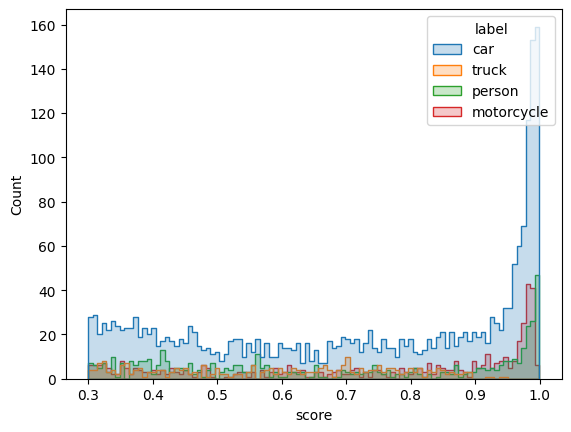

In [ ]:
selected_classes = ['car', 'person', 'motorcycle', 'truck']
sns.histplot(data=df_predictions_allframes.query('label==@selected_classes'), x='score', hue='label', bins=100, element='step')